In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!gid add modeling/fine_tuning_with_clinical_bert.ipynb

Bio_ClinicalBERT	    data      models	preprocess  requirements.txt
Bio_ClinicalBERT_tokenizer  modeling  practice	README.md   tmp


In [2]:
cd /content/drive/MyDrive/CS598/CS598-project/

/content/drive/MyDrive/CS598/CS598-project


In [ ]:
# import pandas as pd
# train = pd.read_csv("data/3days/train.csv")[['ID', 'TEXT', 'Label']]
# test = pd.read_csv("data/3days/test.csv")[['ID', 'TEXT', 'Label']]
# val = pd.read_csv("data/3days/val.csv")[['ID', 'TEXT', 'Label']]

In [ ]:
# display(train.Label.value_counts())
# display(test.Label.value_counts())
# display(val.Label.value_counts())

In [ ]:
!pip install funcsigs -U
!pip install urllib3==1.25.4 
from modeling.utils import *

     |████████████████████████████████| 125 kB 8.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
processors = {
        "readmission": readmissionProcessor
    }
processor = processors['readmission']()
label_list = processor.get_labels()

train_examples = processor.get_train_examples('/content/drive/MyDrive/CS598/CS598-project/data/3days/')
test_example = processor.get_test_examples('/content/drive/MyDrive/CS598/CS598-project/data/3days/')
dev_example = processor.get_dev_examples('/content/drive/MyDrive/CS598/CS598-project/data/3days/')

04/09/2022 15:27:03 - INFO - modeling.utils -   LOOKING AT /content/drive/MyDrive/CS598/CS598-project/data/3days/train.csv


In [ ]:
labels = set(label_list)

In [ ]:
target_names = list(set(labels))
label2idx = {label: idx for idx, label in enumerate(target_names)}
print(label2idx)

{'0': 0, '1': 1}


In [ ]:
len(train_examples)

47792

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 6.9 MB/s 
     |████████████████████████████████| 6.5 MB 55.9 MB/s 
     |████████████████████████████████| 77 kB 9.2 MB/s 
     |████████████████████████████████| 596 kB 56.4 MB/s 
     |████████████████████████████████| 895 kB 64.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import AutoTokenizer, AutoModel
BERT_MODEL = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)
#model = AutoModel.from_pretrained(BERT_MODEL)

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
MAX_SEQ_LENGTH = 150
BATCH_SIZE = 16
train_features = convert_examples_to_features(
        train_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = convert_examples_to_features(
        test_example, label_list, MAX_SEQ_LENGTH, tokenizer)
dev_features = convert_examples_to_features(
        dev_example, label_list, MAX_SEQ_LENGTH, tokenizer)

04/09/2022 15:27:21 - INFO - modeling.utils -   *** Example ***
04/09/2022 15:27:21 - INFO - modeling.utils -   guid: train-0
04/09/2022 15:27:21 - INFO - modeling.utils -   tokens: [CLS] . given history of co ##lon cancer , find ##in ##ces are concerning for meta ##static disease , progressed since , as stated on the previous study . chief complaint : an ##emia hp ##i : 87 ##m with pm ##h of ca ##d s / p distant mi and 3 ##v cab ##g , chronic s ##ys ##to ##lic heart failure with e ##f 30 % , h / o a ##fi ##b not on co ##uma ##din , and multiple cancer ##s ( meta ##static stage 4 co ##lon + bladder cancer ) , with recent admission for n / v / d , diagnosed with il ##eus s / p ng ##t de ##com ##press ##ion and negative micro ##bio ##log ##ic work ##up including si ##g ##mo ##ido ##sco ##py to r / o cm ##v , complicated by ha ##p on van ##c [SEP]
04/09/2022 15:27:21 - INFO - modeling.utils -   input_ids: 101 119 1549 1607 1104 1884 4934 4182 117 1525 1394 7723 1132 6995 1111 27154 27372 

Max Sequence Length: 1059


04/09/2022 15:28:28 - INFO - modeling.utils -   *** Example ***
04/09/2022 15:28:28 - INFO - modeling.utils -   guid: val-0
04/09/2022 15:28:28 - INFO - modeling.utils -   tokens: [CLS] 10 : 11 pm chest ( pre - op p ##a & la ##t ) clip # reason : co ##rona ##ry artery disease admitting diagnosis : co ##rona ##ry artery disease medical condition : 77 year old woman with reason for this examination : pre - op final report indication : 77 year old pre - op for cab ##g . technique : p ##a and lateral radio ##graphs . comparison : findings : the heart is enlarged . there are bilateral p ##le ##ural e ##ff ##usions , right greater than left with associated minor ate ##lect ##atic changes at the lung bases . the pulmonary v ##as ##cula ##ture appears somewhat prominent with an upper zone red ##ist ##ri ##but ##ion . there is no p ##ne ##um ##oth ##orax . the patient has had a prior cab ##g with unchanged appearance of median stern [SEP]
04/09/2022 15:28:28 - INFO - modeling.utils -   input_id

Max Sequence Length: 851
Max Sequence Length: 945


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

def get_data_loader(features, max_seq_length, batch_size, shuffle=True): 

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader
train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
dev_dataloader = get_data_loader(dev_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)


In [ ]:
# import numpy as np
# def evaluate(model, dataloader):
#     model.eval()
#     eval_loss = 0
#     nb_eval_steps = 0
#     predicted_labels, correct_labels = [], []

#     for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
#         batch = tuple(t.to(device) for t in batch)
#         input_ids, input_mask, segment_ids, label_ids = batch

#         with torch.no_grad():
#             output_model = model(input_ids, attention_mask=input_mask,
#                                           token_type_ids=segment_ids, labels=label_ids)

#         outputs = np.argmax(output_model[1].to('cpu'), axis=1)
#         label_ids = np.array(np.array(label_ids.to('cpu')))
        
#         predicted_labels += list(outputs)
#         correct_labels += list(label_ids)
        
#         eval_loss += output_model[0].mean().item()
#         nb_eval_steps += 1

#     eval_loss = eval_loss / nb_eval_steps
    
#     correct_labels = np.array(correct_labels)
#     predicted_labels = np.array(predicted_labels)
        
#     return eval_loss, correct_labels, predicted_labels

In [ ]:
from transformers import BertForSequenceClassification
#torch.cuda.empty_cache()
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = len(label2idx))
model.to(device)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
!pip install urllib3==1.25.4 

In [ ]:
!pip uninstall datascience -y

Found existing installation: datascience 0.10.6
Uninstalling datascience-0.10.6:
  Successfully uninstalled datascience-0.10.6


In [ ]:
!pip install pytorch-pretrained-bert pytorch-nlp -U

     |████████████████████████████████| 123 kB 7.4 MB/s eta 0:00:01
     |████████████████████████████████| 90 kB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 80.4 MB/s 
     |████████████████████████████████| 79 kB 11.4 MB/s 
     |████████████████████████████████| 8.7 MB 76.8 MB/s 


In [ ]:

# train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
# dev_dataloader = get_data_loader(dev_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
# test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)

In [ ]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = len(label2idx))
model.to(device)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:

from transformers.optimization import get_linear_schedule_with_warmup
from pytorch_pretrained_bert.optimization import BertAdam
GRADIENT_ACCUMULATION_STEPS = 4
NUM_TRAIN_EPOCHS = 20
LEARNING_RATE = 5e-5
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5

num_train_steps = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

#optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, correct_bias=True)
optimizer = BertAdam(optimizer_grouped_parameters,
                             lr=LEARNING_RATE,
                             warmup=WARMUP_PROPORTION,
                             t_total=num_train_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)

In [ ]:
def train(train_loader, epoch):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
        loss = outputs[0]

        if GRADIENT_ACCUMULATION_STEPS > 1:
          loss = loss / GRADIENT_ACCUMULATION_STEPS
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        tr_loss += loss.item()

        nb_tr_steps = nb_tr_steps + 1
    tr_loss_epoch = tr_loss /  nb_tr_steps  
    model_to_save = model.module if hasattr(model, 'module') else model
    #output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
    torch.save(model_to_save.state_dict(), f'/content/drive/MyDrive/CS598/CS598-project/tmp/clinicalbert_new_{str(epoch)}.pt')  
    print('end training!') 
    return tr_loss_epoch  
        # your code here
        #raise NotImplementedError

def test(loader, epoch):
    model.eval()
    correct = 0
    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(loader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            output_model = model(input_ids, attention_mask=input_mask,
                                          token_type_ids=segment_ids, labels=label_ids)
        pred = output_model[1].argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == label_ids).sum())  # Check against ground-truth labels.
        eval_loss += output_model[0].mean().item()
        nb_eval_steps += 1
    avg_loss = eval_loss / nb_eval_steps 
    avg_acc = correct / len(loader.dataset)
    
    return avg_loss, avg_acc  # Derive ratio of correct predictions.

        # outputs = np.argmax(output_model[1].to('cpu'), axis=1)
        # label_ids = np.array(np.array(label_ids.to('cpu')))
        
        # predicted_labels += list(outputs)
        # correct_labels += list(label_ids)
 
GRADIENT_ACCUMULATION_STEPS = 1
for epoch in range(3):
    train(train_dataloader, epoch)
    train_loss, train_acc = test(train_dataloader, epoch)
    test_loss, test_acc = test(dev_dataloader)
    print(f'Epoch: {epoch + 1:03d}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}')
    print(f'Epoch: {epoch + 1:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Training iteration:   0%|          | 0/2987 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  next_m.mul_(beta1).add_(1 - beta1, grad)
Training iteration: 100%|██████████| 2987/2987 [16:08<00:00,  3.08it/s]


end training!


Evaluation iteration: 100%|██████████| 361/361 [00:33<00:00, 10.74it/s]


Epoch: 001, Train loss: 2988.0000, Test loss: 362.0000
Epoch: 001, Train Acc: 0.5001, Test Acc: 0.5170


Training iteration: 100%|██████████| 2987/2987 [16:05<00:00,  3.09it/s]


end training!


Evaluation iteration: 100%|██████████| 361/361 [00:33<00:00, 10.73it/s]


Epoch: 002, Train loss: 2988.0000, Test loss: 362.0000
Epoch: 002, Train Acc: 0.5001, Test Acc: 0.5170


Training iteration: 100%|██████████| 2987/2987 [16:04<00:00,  3.10it/s]


end training!


Evaluation iteration: 100%|██████████| 361/361 [00:33<00:00, 10.74it/s]

Epoch: 003, Train loss: 2988.0000, Test loss: 362.0000
Epoch: 003, Train Acc: 0.5001, Test Acc: 0.5170


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/CS598/CS598-project/tmp/clinicalbert_epoch1.pt'))

<All keys matched successfully>

In [ ]:
model.eval()
correct = 0
eval_loss = 0
nb_eval_steps = 0
for step, batch in enumerate(tqdm(dev_dataloader, desc="Evaluation iteration")):
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids = batch

    with torch.no_grad():
        output_model = model(input_ids, attention_mask=input_mask,
                                      token_type_ids=segment_ids, labels=label_ids)
    pred = output_model[1].argmax(dim=1)  # Use the class with highest probability.
    correct += int((pred == label_ids).sum())  # Check against ground-truth labels.
    eval_loss += output_model[0].mean().item()
    nb_eval_steps += 1
avg_loss = eval_loss / nb_eval_steps 
avg_acc = correct / len(dev_dataloader.dataset)
print(f'Epoch: {1 + 1:03d}, Train loss: {avg_loss:.4f}, Test loss: {avg_acc:.4f}')

Evaluation iteration: 100%|██████████| 361/361 [00:33<00:00, 10.75it/s]

Epoch: 002, Train loss: 0.6931, Test loss: 0.5170


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/CS598/CS598-project/tmp/clinicalbert_epoch2.pt'))

<All keys matched successfully>

In [ ]:
model.eval()
correct = 0
eval_loss = 0
nb_eval_steps = 0
for step, batch in enumerate(tqdm(dev_dataloader, desc="Evaluation iteration")):
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids = batch

    with torch.no_grad():
        output_model = model(input_ids, attention_mask=input_mask,
                                      token_type_ids=segment_ids, labels=label_ids)
    pred = output_model[1].argmax(dim=1)  # Use the class with highest probability.
    correct += int((pred == label_ids).sum())  # Check against ground-truth labels.
    eval_loss += output_model[0].mean().item()
    nb_eval_steps += 1
avg_loss = eval_loss / nb_eval_steps 
avg_acc = correct / len(dev_dataloader.dataset)
print(f'Epoch: {2 + 1:03d}, Train loss: {avg_loss:.4f}, Test acc: {avg_acc:.4f}')

Evaluation iteration: 100%|██████████| 361/361 [00:33<00:00, 10.74it/s]

Epoch: 003, Train loss: 0.6899, Test acc: 0.5204


In [ ]:
for model_path in ['tmp/clinicalbert_new_0.pt', 'tmp/clinicalbert_new_1.pt', 'tmp/clinicalbert_new_2.pt']:
  model.load_state_dict(torch.load(model_path))
  model.eval()
  correct = 0
  eval_loss = 0
  nb_eval_steps = 0
  for step, batch in enumerate(tqdm(dev_dataloader, desc="Evaluation iteration")):
      batch = tuple(t.to(device) for t in batch)
      input_ids, input_mask, segment_ids, label_ids = batch

      with torch.no_grad():
          output_model = model(input_ids, attention_mask=input_mask,
                                        token_type_ids=segment_ids, labels=label_ids)
      pred = output_model[1].argmax(dim=1)  # Use the class with highest probability.
      correct += int((pred == label_ids).sum())  # Check against ground-truth labels.
      eval_loss += output_model[0].mean().item()
      nb_eval_steps += 1
  avg_loss = eval_loss / nb_eval_steps 
  avg_acc = correct / len(dev_dataloader.dataset)
  print(f'Epoch: {2 + 1:03d}, Train loss: {avg_loss:.4f}, Test acc: {avg_acc:.4f}')

Evaluation iteration: 100%|██████████| 361/361 [00:33<00:00, 10.72it/s]


Epoch: 003, Train loss: 0.7230, Test acc: 0.5170


Evaluation iteration: 100%|██████████| 361/361 [00:33<00:00, 10.73it/s]


Epoch: 003, Train loss: 0.7230, Test acc: 0.5170


Evaluation iteration: 100%|██████████| 361/361 [00:33<00:00, 10.71it/s]

Epoch: 003, Train loss: 0.7230, Test acc: 0.5170


In [ ]:

from transformers.optimization import get_linear_schedule_with_warmup
from pytorch_pretrained_bert.optimization import BertAdam
GRADIENT_ACCUMULATION_STEPS = 4
NUM_TRAIN_EPOCHS = 20
LEARNING_RATE = 5e-5
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5

num_train_steps = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

#optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, correct_bias=True)
optimizer = BertAdam(optimizer_grouped_parameters,
                             lr=LEARNING_RATE,
                             warmup=WARMUP_PROPORTION,
                             t_total=num_train_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)

In [ ]:
import torch
import os
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support
import copy
OUTPUT_DIR = "/tmp/"
MODEL_FILE_NAME = "pytorch_model.bin"
PATIENCE = 5

loss_history = []
train_loss_history = []
no_improvement = 0


for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch
        with torch.set_grad_enabled(True):
          model.zero_grad()
          outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
          loss = outputs[0]

          if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS
          
          loss.backward()
          tr_loss += loss.item()

          if ((step + 1) % GRADIENT_ACCUMULATION_STEPS == 0  or (step+1) == len(train_dataloader)):
              torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)  
              optimizer.step()
              scheduler.step()
              #optimizer.zero_grad()
          nb_tr_steps = nb_tr_steps + 1
    tr_loss_epoch = tr_loss /  nb_tr_steps    
    print('end training!')   
    dev_loss, _, _ = evaluate(model, dev_dataloader)
    model.eval()
    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dev_dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            output_model = model(input_ids, attention_mask=input_mask,
                                          token_type_ids=segment_ids, labels=label_ids)

        # outputs = np.argmax(output_model[1].to('cpu'), axis=1)
        # label_ids = np.array(np.array(label_ids.to('cpu')))
        
        # predicted_labels += list(outputs)
        # correct_labels += list(label_ids)
        
        eval_loss += output_model[0].mean().item()
        nb_eval_steps += 1

    #eval_loss = eval_loss / nb_eval_steps
    
    print("Loss history:", loss_history)
    print("Dev loss:", eval_loss)
    print(train_loss_history)
    
    if len(loss_history) == 0 or eval_loss < min(loss_history):
        print('improved!!!!!')
        no_improvement = 0
        model_to_save = model.module if hasattr(model, 'module') else model
        #output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), '/content/drive/MyDrive/CS598/CS598-project/tmp/clinicalbert.pt')
    else:
        no_improvement += 1
    
    if no_improvement >= PATIENCE: 
        print("No improvement on development set. Finish training.")
        break
        
    
    loss_history.append(eval_loss)
    train_loss_history.append(tr_loss_epoch)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Training iteration:   0%|          | 0/2987 [00:00<?, ?it/s]

end training!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluation iteration:   0%|          | 0/361 [00:00<?, ?it/s]

Loss history: [250.2131343483925]
Dev loss: 249.0604112148285
[0.17616248962908715]
improved!!!!!


Epoch:   5%|▌         | 1/20 [14:46<4:40:43, 886.48s/it]

Training iteration:   0%|          | 0/2987 [00:00<?, ?it/s]

end training!


Evaluation iteration:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch:  10%|█         | 2/20 [29:29<4:25:17, 884.33s/it]

Loss history: [250.2131343483925, 249.0604112148285]
Dev loss: 258.06958642601967
[0.17616248962908715, 0.17279361256257642]


Training iteration:   0%|          | 0/2987 [00:00<?, ?it/s]

end training!


Evaluation iteration:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch:  15%|█▌        | 3/20 [44:12<4:10:26, 883.89s/it]

Loss history: [250.2131343483925, 249.0604112148285, 258.06958642601967]
Dev loss: 251.83734387159348
[0.17616248962908715, 0.17279361256257642, 0.1721814905206296]


Training iteration:   0%|          | 0/2987 [00:00<?, ?it/s]

end training!


Evaluation iteration:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch:  20%|██        | 4/20 [58:55<3:55:32, 883.29s/it]

Loss history: [250.2131343483925, 249.0604112148285, 258.06958642601967, 251.83734387159348]
Dev loss: 250.4369950890541
[0.17616248962908715, 0.17279361256257642, 0.1721814905206296, 0.1761079015073706]


Training iteration:   0%|          | 0/2987 [00:00<?, ?it/s]

end training!


Evaluation iteration:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch:  25%|██▌       | 5/20 [1:13:37<3:40:47, 883.14s/it]

Loss history: [250.2131343483925, 249.0604112148285, 258.06958642601967, 251.83734387159348, 250.4369950890541]
Dev loss: 252.9526429772377
[0.17616248962908715, 0.17279361256257642, 0.1721814905206296, 0.1761079015073706, 0.17555426306097174]


Training iteration:   0%|          | 0/2987 [00:00<?, ?it/s]

end training!


Evaluation iteration:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch:  25%|██▌       | 5/20 [1:28:21<4:25:03, 1060.23s/it]

Loss history: [250.2131343483925, 249.0604112148285, 258.06958642601967, 251.83734387159348, 250.4369950890541, 252.9526429772377]
Dev loss: 252.62248814105988
[0.17616248962908715, 0.17279361256257642, 0.1721814905206296, 0.1761079015073706, 0.17555426306097174, 0.17495915656868813]
No improvement on development set. Finish training.


In [ ]:
for model_path in ['tmp/clinicalbert_epoch1.pt', 'tmp/clinicalbert_epoch2.pt']:
  model.load_state_dict(torch.load(model_path))
  model.eval()
  correct = 0
  eval_loss = 0
  nb_eval_steps = 0
  for step, batch in enumerate(tqdm(dev_dataloader, desc="Evaluation iteration")):
      batch = tuple(t.to(device) for t in batch)
      input_ids, input_mask, segment_ids, label_ids = batch

      with torch.no_grad():
          output_model = model(input_ids, attention_mask=input_mask,
                                        token_type_ids=segment_ids, labels=label_ids)
      pred = output_model[1].argmax(dim=1)  # Use the class with highest probability.
      correct += int((pred == label_ids).sum())  # Check against ground-truth labels.
      eval_loss += output_model[0].mean().item()
      nb_eval_steps += 1
  avg_loss = eval_loss / nb_eval_steps 
  avg_acc = correct / len(dev_dataloader.dataset)
  print(f'Epoch: {2 + 1:03d}, Train loss: {avg_loss:.4f}, Test acc: {avg_acc:.4f}')

Evaluation iteration: 100%|██████████| 361/361 [00:33<00:00, 10.69it/s]


Epoch: 003, Train loss: 0.6931, Test acc: 0.5170


Evaluation iteration: 100%|██████████| 361/361 [00:33<00:00, 10.71it/s]

Epoch: 003, Train loss: 0.6899, Test acc: 0.5204


In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_history)
plt.plot(loss_history)
plt.show()

In [ ]:
# model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
# model = BertForSequenceClassification.from_pretrained(BERT_MODEL, state_dict=model_state_dict, num_labels = len(target_names))
# model.to(device)

# model.eval()

# _, train_correct, train_predicted = evaluate(model, train_dataloader)
# _, dev_correct, dev_predicted = evaluate(model, dev_dataloader)
# _, test_correct, test_predicted = evaluate(model, test_dataloader)

# print("Training performance:", precision_recall_fscore_support(train_correct, train_predicted, average="micro"))
# print("Development performance:", precision_recall_fscore_support(dev_correct, dev_predicted, average="micro"))
# print("Test performance:", precision_recall_fscore_support(test_correct, test_predicted, average="micro"))

# bert_accuracy = np.mean(test_predicted == test_correct)

# print(classification_report(test_correct, test_predicted, target_names=target_names))

In [ ]:
cd modeling

/content/drive/MyDrive/CS598/CS598-project/modeling


In [ ]:
from attention_viz import *

in the modeling class


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('white')
sns.set_context('talk', font_scale = 1)
import os
bert_config = BertConfig.from_json_file('/content/drive/MyDrive/CS598/CS598-project/Bio_ClinicalBERT/bert_config.json')

In [ ]:
def transpose_for_scores(config, x):
    new_x_shape = x.size()[:-1] + (config.num_attention_heads, int(config.hidden_size / config.num_attention_heads))
    x = x.view(*new_x_shape)
    return x.permute(0, 2, 1, 3)

In [ ]:
def get_attention_scores(model,i,text):
    tokenized=tokenizer.tokenize(text)

    indexed_tokens=tokenizer.convert_tokens_to_ids(tokenized)

    segment_ids=[0]*len(indexed_tokens)
    t_tensor=torch.tensor([indexed_tokens])
    s_ids=torch.tensor([segment_ids])

    outputs_query= []
    outputs_key= []

    def hook_query(module, input, output):
        #print ('in query')
        outputs_query.append(output)

    def hook_key(module, input, output):
        #print ('in key')
        outputs_key.append(output)

    model.bert.encoder.layer[i].attention.self.query.register_forward_hook(hook_query)
    model.bert.encoder.layer[i].attention.self.key.register_forward_hook(hook_key)
    l=model(t_tensor,s_ids)
    
    query_layer = transpose_for_scores(bert_config,outputs_query[0])
    key_layer = transpose_for_scores(bert_config,outputs_key[0])
    
    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
    attention_scores = attention_scores / math.sqrt(int(bert_config.hidden_size / bert_config.num_attention_heads))
    attention_probs = nn.Softmax(dim=-1)(attention_scores)
    
    return attention_probs,tokenized

In [ ]:
model.to('cpu')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
text=' he has experienced acute on chronic diastolic heart failure in the setting of volume overload due to his sepsis.'
x,tokens=get_attention_scores(model,0,text)

In [ ]:
map1=np.asarray(x[0][1].detach().numpy())
len(tokens)

24

In [ ]:
% matplotlib inline

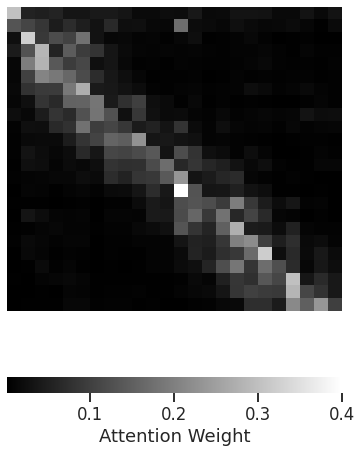

In [ ]:
f, ax = plt.subplots(figsize=(6,8))
sns.heatmap(map1, annot=False, fmt="f", ax=ax, xticklabels = False, yticklabels = False, vmax=0.4, cmap='gray', cbar_kws={'label':'Attention Weight', 'orientation':'horizontal'}, rasterized = True)


<Figure size 432x288 with 0 Axes>

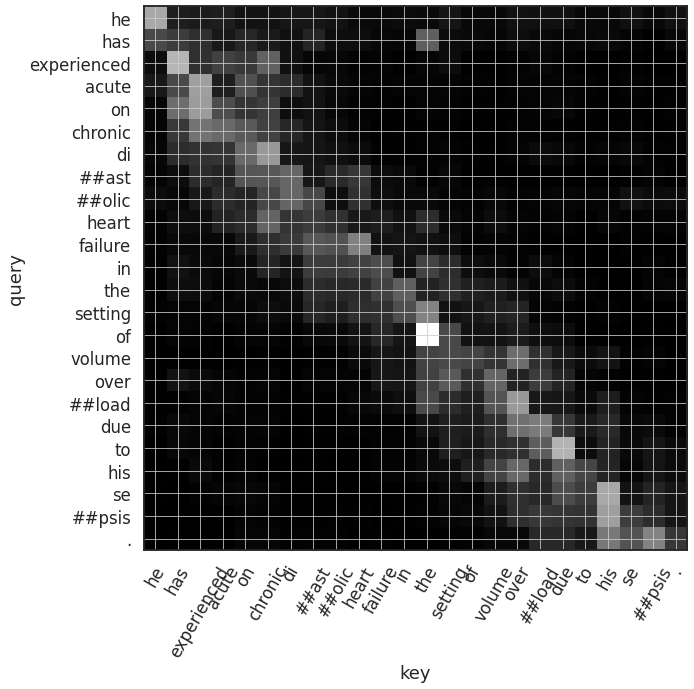

In [ ]:
plt.clf()

f=plt.figure(figsize=(10,10))
ax = f.add_subplot(1,1,1)
i=ax.imshow(map1,interpolation='nearest',cmap='gray')

ax.set_yticks(range(len(tokens)))
ax.set_yticklabels(tokens)

ax.set_xticks(range(len(tokens)))
ax.set_xticklabels(tokens,rotation=60)

ax.set_xlabel('key')
ax.set_ylabel('query')

ax.grid(linewidth = 0.8)

 attention.py   'data_preprocessing.ipynb의 사본'   __pycache__/     utils.py
 bert_utils.py   file_utils.py                      training.ipynb
